#### This notebook can be run in the docker container https://github.com/GPlates/pygplates-tutorials

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
from shapely.geometry.polygon import LinearRing

import Utils, pygplates

In [4]:
import glob
import os
rotation_files=(glob.glob('./Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/*.rot'))
rotation_files

['./Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/AUSANT_DeformingModel_2016_v2_fixed_crossovers.rot',
 './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/AUSLHR_DeformingModel_2016_v2_fixed_crossovers.rot',
 './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/Andes_Flat_Slabs_2016_v2_fixed_crossovers.rot',
 './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/Andes_Rotations_2016_v2_fixed_crossovers.rot',
 './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/Eurasia_Arabia_DeformingModel_Rotations_2016_v2_fixed_crossovers.rot',
 './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/Global_EB_250-0Ma_GK07_2016_v2_fixed_crossovers.rot',
 './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/Global_EB_410-250Ma_GK07_2016_v2_fixed_crossovers.rot',
 './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/ROTs/GoM_displacements_as_poles_2016_v2

In [7]:
input_directory='./Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD'
topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)
#topology_filenames

reconstructing at 208 Ma...


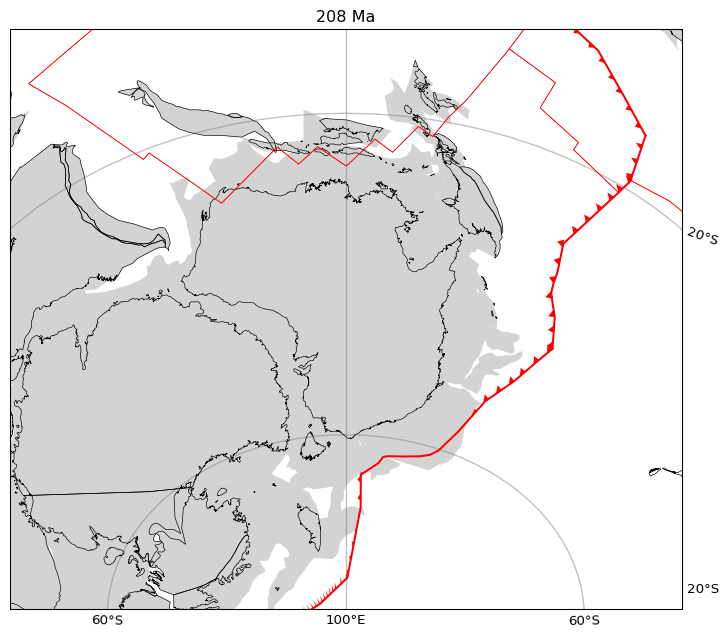

Done


In [80]:
# The central point of the Orthographic projection
#
central_lon=100.0
central_lat=-50.0

rotation_files = rotation_files
coastlines_file = './Coastlines/Global_coastlines_low_res.shp'
# continent_polygons_file = './StaticPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp'
# continent_polygons_file = './Global_EarthByte_Paleozoic_plate_boundaries_2016_v2.gpml' #Error opening file './Global_EarthByte_Paleozoic_plate_boundaries_2016_v2.gpml' for reading
# continent_polygons_file = './Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_2016_v2.gpml'#Error opening file './Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_2016_v2.gpml' for reading
continent_polygons_file = './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2016_v3.shp'

time=208
anchor_plate_id=701701
print(f"reconstructing at {time} Ma...")

resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_features, rotation_files, resolved_topologies, time, 
                             shared_boundary_sections, anchor_plate_id=anchor_plate_id)
#coastlines
reconstructed_geometries = []
pygplates.reconstruct(
                coastlines_file, 
                rotation_files, 
                reconstructed_geometries, 
                time, anchor_plate_id=anchor_plate_id)

#continent polygons
reconstructed_continents = []
pygplates.reconstruct(
                continent_polygons_file, 
                rotation_files, 
                reconstructed_continents, 
                time, anchor_plate_id=anchor_plate_id)

#subduction zones
subduction_geoms=[]
Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)



# plot the map
fig = plt.figure(figsize=(12,8),dpi=96)
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_lon, central_latitude=central_lat))
#ax = plt.axes(projection=ccrs.Robinson(central_longitude=30))

ax.set_extent([55,145,-5,-80])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='-')

#Editing labels in the axis 
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlocator = mticker.FixedLocator(range(-180,180,30))
# gl.ylocator = mticker.FixedLocator(range(-90,90,15))
# # gl.xformatter = LONGITUDE_FORMATTER
# # gl.yformatter = LATITUDE_FORMATTER
# # gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
# # gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylocator = mticker.FixedLocator([-60, -20])
gl.xlocator = mticker.FixedLocator([100])
gl.top_labels = False
gl.left_labels = False


#plot coastlines
for geom in reconstructed_geometries:
    lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='black', linewidth=.5, #the coastlines in black
         transform=ccrs.Geodetic(),
    )

#plot topological plates boundaries
for t in resolved_topologies:
    lat, lon =zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='red', linewidth=.5, #the topological plates boundaries in blue
         transform=ccrs.Geodetic(),
    )

#plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='red', linewidth=1.5, #the subduction zones in blue
         transform=ccrs.Geodetic(),
    )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='red', edgecolor=None, alpha=1)

#plot continent polygons        
date_line_wrapper = pygplates.DateLineWrapper(30.0)
for polygon in reconstructed_continents:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        ring = LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()])
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='lightgray', edgecolor=None, alpha=1)       

# plt.text(120, -45, '45\N{DEGREE SIGN}S',
#          horizontalalignment='center',
#          transform=ccrs.Geodetic())

# plt.text(100, -60, "Australia", size=20, rotation=0.,
#          ha="center", va="center",
#          transform=ccrs.Geodetic())

plt.title(f'{time} Ma')

plt.show()
print(f'Done')


#fig.savefig('./Reconstruction_anchor_701701_'+ str(time)+'Ma.pdf', dpi=300, bbox_inches="tight")


reconstructing at 208 Ma...


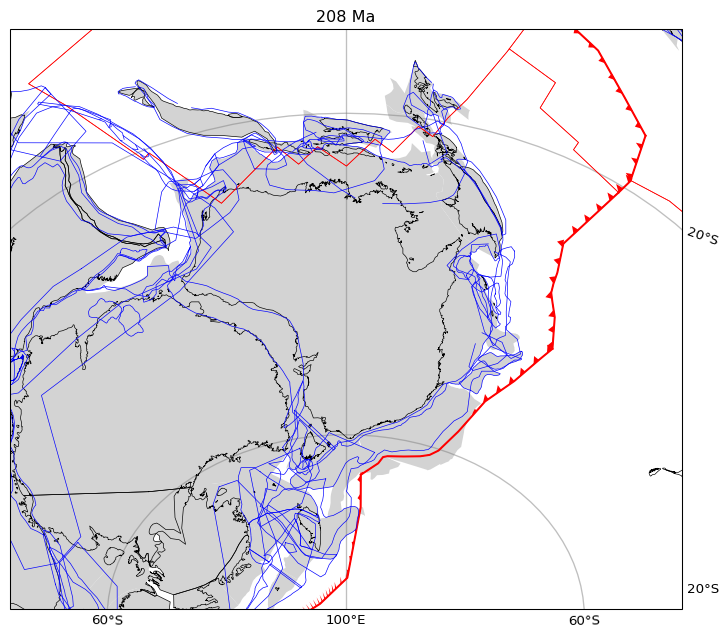

Done


In [81]:
# The central point of the Orthographic projection
#
central_lon=100.0
central_lat=-50.0

rotation_files = rotation_files
coastlines_file = './Coastlines/Global_coastlines_low_res.shp'
# continent_polygons_file = './StaticPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp'
# continent_polygons_file = './Global_EarthByte_Paleozoic_plate_boundaries_2016_v2.gpml' #Error opening file './Global_EarthByte_Paleozoic_plate_boundaries_2016_v2.gpml' for reading
# continent_polygons_file = './Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_2016_v2.gpml'#Error opening file './Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_2016_v2.gpml' for reading
continent_polygons_file = './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2016_v3.shp'
COB_file = './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_COB_Terranes_2016_v2.gpml'

time=208
anchor_plate_id=701701
print(f"reconstructing at {time} Ma...")

resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_features, rotation_files, resolved_topologies, time, 
                             shared_boundary_sections, anchor_plate_id=anchor_plate_id)

#coastlines
reconstructed_geometries = []
pygplates.reconstruct(
                coastlines_file, 
                rotation_files, 
                reconstructed_geometries, 
                time, anchor_plate_id=anchor_plate_id)
#COB
reconstructed_COB = []
pygplates.reconstruct(
                COB_file, 
                rotation_files, 
                reconstructed_COB, 
                time, anchor_plate_id=anchor_plate_id)

#continent polygons
reconstructed_continents = []
pygplates.reconstruct(
                continent_polygons_file, 
                rotation_files, 
                reconstructed_continents, 
                time, anchor_plate_id=anchor_plate_id)

#subduction zones
subduction_geoms=[]
Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)



# plot the map
fig = plt.figure(figsize=(12,8),dpi=96)
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_lon, central_latitude=central_lat))
#ax = plt.axes(projection=ccrs.Robinson(central_longitude=30))

ax.set_extent([55,145,-5,-80])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='-')

#Editing labels in the axis 
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlocator = mticker.FixedLocator(range(-180,180,30))
# gl.ylocator = mticker.FixedLocator(range(-90,90,15))
# # gl.xformatter = LONGITUDE_FORMATTER
# # gl.yformatter = LATITUDE_FORMATTER
# # gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
# # gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylocator = mticker.FixedLocator([-60, -20])
gl.xlocator = mticker.FixedLocator([100])
gl.top_labels = False
gl.left_labels = False


#plot coastlines
for geom in reconstructed_geometries:
    lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='black', linewidth=.5, #the coastlines in black
         transform=ccrs.Geodetic(),
    )

#plot topological plates boundaries
for t in resolved_topologies:
    lat, lon =zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='red', linewidth=.5, #the topological plates boundaries in blue
         transform=ccrs.Geodetic(),
    )

#plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='red', linewidth=1.5, #the subduction zones in blue
         transform=ccrs.Geodetic(),
    )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='red', edgecolor=None, alpha=1)

#plot continent polygons        
date_line_wrapper = pygplates.DateLineWrapper(30.0)
for polygon in reconstructed_continents:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        ring = LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()])
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='lightgray', edgecolor=None, alpha=1)       

#plot coastlines
for geom in reconstructed_COB:
    lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='blue', linewidth=.5, #the coastlines in black
         transform=ccrs.Geodetic(),
    )
# plt.text(120, -45, '45\N{DEGREE SIGN}S',
#          horizontalalignment='center',
#          transform=ccrs.Geodetic())

# plt.text(100, -60, "Australia", size=20, rotation=0.,
#          ha="center", va="center",
#          transform=ccrs.Geodetic())

plt.title(f'{time} Ma')

plt.show()
print(f'Done')


#fig.savefig('./Reconstruction_anchor_701701_'+ str(time)+'Ma.pdf', dpi=300, bbox_inches="tight")


reconstructing at 208 Ma...


AttributeError: 'LatLonPolyline' object has no attribute 'get_exterior_points'

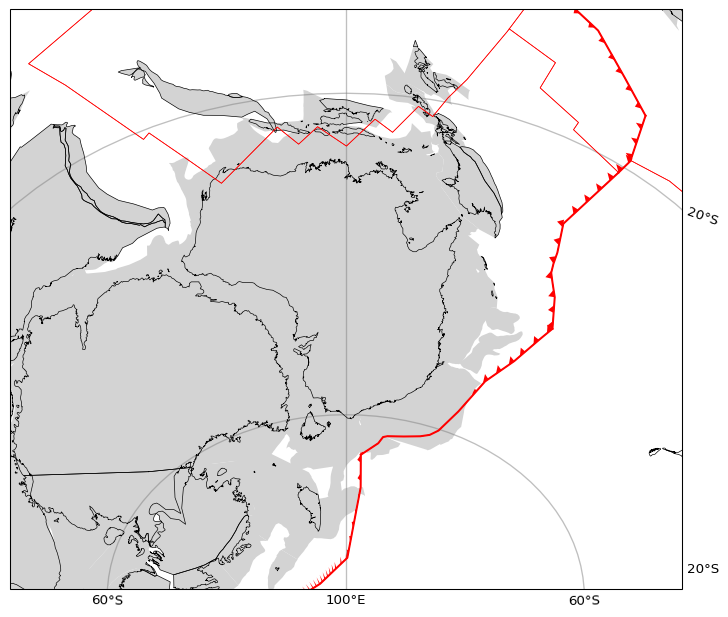

In [79]:
# The central point of the Orthographic projection
#
central_lon=100.0
central_lat=-50.0

rotation_files = rotation_files
coastlines_file = './Coastlines/Global_coastlines_low_res.shp'
# continent_polygons_file = './StaticPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp'
# continent_polygons_file = './Global_EarthByte_Paleozoic_plate_boundaries_2016_v2.gpml' #Error opening file './Global_EarthByte_Paleozoic_plate_boundaries_2016_v2.gpml' for reading
# continent_polygons_file = './Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_2016_v2.gpml'#Error opening file './Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_2016_v2.gpml' for reading
continent_polygons_file = './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2016_v3.shp'
COB_file = './Global_Model_WD_Internal_Release_2016_v2_r1147_Sibumasu_OptionD/StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_COB_Terranes_2016_v2.gpml'

time=208
anchor_plate_id=701701
print(f"reconstructing at {time} Ma...")

resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_features, rotation_files, resolved_topologies, time, 
                             shared_boundary_sections, anchor_plate_id=anchor_plate_id)

#coastlines
reconstructed_geometries = []
pygplates.reconstruct(
                coastlines_file, 
                rotation_files, 
                reconstructed_geometries, 
                time, anchor_plate_id=anchor_plate_id)
#COB
reconstructed_COB = []
pygplates.reconstruct(
                COB_file, 
                rotation_files, 
                reconstructed_COB, 
                time, anchor_plate_id=anchor_plate_id)

#continent polygons
reconstructed_continents = []
pygplates.reconstruct(
                continent_polygons_file, 
                rotation_files, 
                reconstructed_continents, 
                time, anchor_plate_id=anchor_plate_id)

#subduction zones
subduction_geoms=[]
Utils.get_subduction_geometries(subduction_geoms, shared_boundary_sections)



# plot the map
fig = plt.figure(figsize=(12,8),dpi=96)
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_lon, central_latitude=central_lat))
#ax = plt.axes(projection=ccrs.Robinson(central_longitude=30))

ax.set_extent([55,145,-5,-80])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='-')

#Editing labels in the axis 
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlocator = mticker.FixedLocator(range(-180,180,30))
# gl.ylocator = mticker.FixedLocator(range(-90,90,15))
# # gl.xformatter = LONGITUDE_FORMATTER
# # gl.yformatter = LATITUDE_FORMATTER
# # gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
# # gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}
gl.ylocator = mticker.FixedLocator([-60, -20])
gl.xlocator = mticker.FixedLocator([100])
gl.top_labels = False
gl.left_labels = False


#plot coastlines
for geom in reconstructed_geometries:
    lat, lon =zip(*(geom.get_reconstructed_geometry().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='black', linewidth=.5, #the coastlines in black
         transform=ccrs.Geodetic(),
    )

#plot topological plates boundaries
for t in resolved_topologies:
    lat, lon =zip(*(t.get_resolved_boundary().to_lat_lon_list()))
    plt.plot(lon, lat,
         color='red', linewidth=.5, #the topological plates boundaries in blue
         transform=ccrs.Geodetic(),
    )

#plot subduction zones
for geom, aspect in subduction_geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='red', linewidth=1.5, #the subduction zones in blue
         transform=ccrs.Geodetic(),
    )
    teeth = Utils.get_subduction_teeth(lon, lat, triangle_aspect=aspect)
    for tooth in teeth:
        ring = LinearRing(tooth)
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='red', edgecolor=None, alpha=1)

#plot continent polygons        
date_line_wrapper = pygplates.DateLineWrapper(30.0)
for polygon in reconstructed_continents:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        ring = LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()])
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='lightgray', edgecolor=None, alpha=1)       

#plot COB
date_line_wrapper = pygplates.DateLineWrapper(30.0)
for polygon in reconstructed_COB:
    wrapped_polygons = date_line_wrapper.wrap(polygon.get_reconstructed_geometry())
    for poly in wrapped_polygons:
        ring = LinearRing([(p.get_longitude(), p.get_latitude()) for p in poly.get_exterior_points()])
        ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='lightgray', edgecolor=None, alpha=1)       
# plt.text(120, -45, '45\N{DEGREE SIGN}S',
#          horizontalalignment='center',
#          transform=ccrs.Geodetic())

# plt.text(100, -60, "Australia", size=20, rotation=0.,
#          ha="center", va="center",
#          transform=ccrs.Geodetic())

plt.title(f'{time} Ma')

plt.show()
print(f'Done')


#fig.savefig('./Reconstruction_anchor_701701_'+ str(time)+'Ma.pdf', dpi=300, bbox_inches="tight")
